### Library installation

In [1]:
!pip install timm

^C


In [108]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip cache purge

Defaulting to user installation because normal site-packages is not writeable


Files removed: 0


## Load and Preprocess Data

In [129]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import tensorflow as tf
import random

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Define paths to your dataset
base_dir = "C:\\Users\\sirin\\Desktop\\newhandpd\\data"
healthy_dir = os.path.join(base_dir, 'data_healthy')
sick_dir = os.path.join(base_dir, 'data_sick')

# Define the image size and batch size
image_size = (299, 299)  # As required by InceptionV4
batch_size = 16
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

# Create new directories for splits
split_base_dir = "C:\\Users\\sirin\\Desktop\\newhandpd\\data_splits"
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Class-specific subdirectories
for split in ['train', 'val', 'test']:
    for class_name in ['Healthy', 'Sick']:
        os.makedirs(os.path.join(split_base_dir, split, class_name), exist_ok=True)

# Function to safely process images and split data
def safe_split_and_copy(source_dir, class_name, target_dirs, split_ratios):
    """
    Process images in the source directory, validate them, and split into train, val, and test.

    Args:
        source_dir (str): Path to the original dataset directory.
        class_name (str): Name of the class (e.g., 'Healthy', 'Sick').
        target_dirs (dict): Dictionary containing paths for train, val, and test directories.
        split_ratios (tuple): Ratios for splitting (train, val, test).
    """
    # Collect valid image file paths
    valid_files = []
    for root, _, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.splitext(file)[-1].lower() not in valid_extensions:
                print(f"Removing non-image file: {file_path}")
                os.remove(file_path)
                continue

            try:
                with Image.open(file_path) as img:
                    img.verify()
                valid_files.append(file_path)
            except (UnidentifiedImageError, IOError):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)

    # Split data with fixed random state for reproducibility
    train_files, test_files = train_test_split(valid_files, test_size=(split_ratios[1] + split_ratios[2]), random_state=SEED)
    val_files, test_files = train_test_split(test_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=SEED)

    # Copy files to corresponding directories
    for file_list, target_dir in zip([train_files, val_files, test_files], [target_dirs["train"], target_dirs["val"], target_dirs["test"]]):
        target_class_dir = os.path.join(target_dir, class_name)
        for file_path in file_list:
            shutil.copy(file_path, target_class_dir)

# Split and organize data for both classes
safe_split_and_copy(healthy_dir, 'Healthy', {"train": train_dir, "val": val_dir, "test": test_dir}, (0.6, 0.2, 0.2))
safe_split_and_copy(sick_dir, 'Sick', {"train": train_dir, "val": val_dir, "test": test_dir}, (0.6, 0.2, 0.2))

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

print("Train class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)


Found 356 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Train class indices: {'Healthy': 0, 'Sick': 1}
Validation class indices: {'Healthy': 0, 'Sick': 1}
Test class indices: {'Healthy': 0, 'Sick': 1}


### Data viz

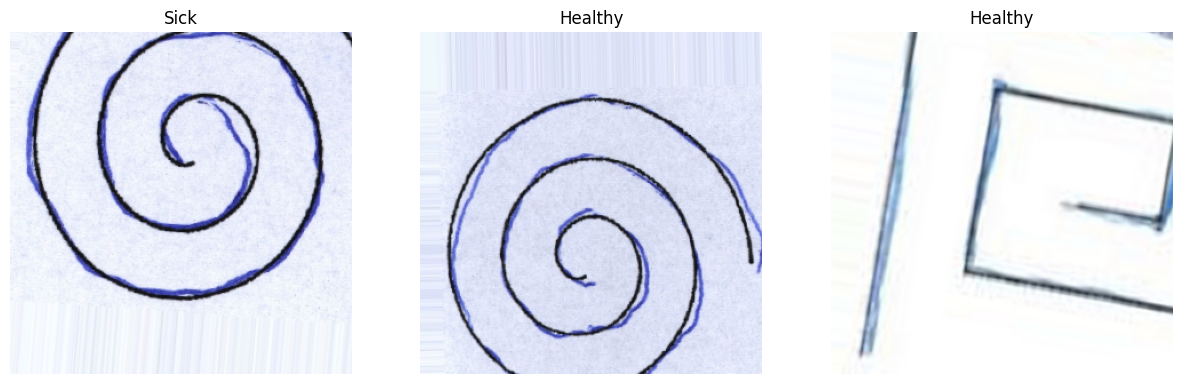

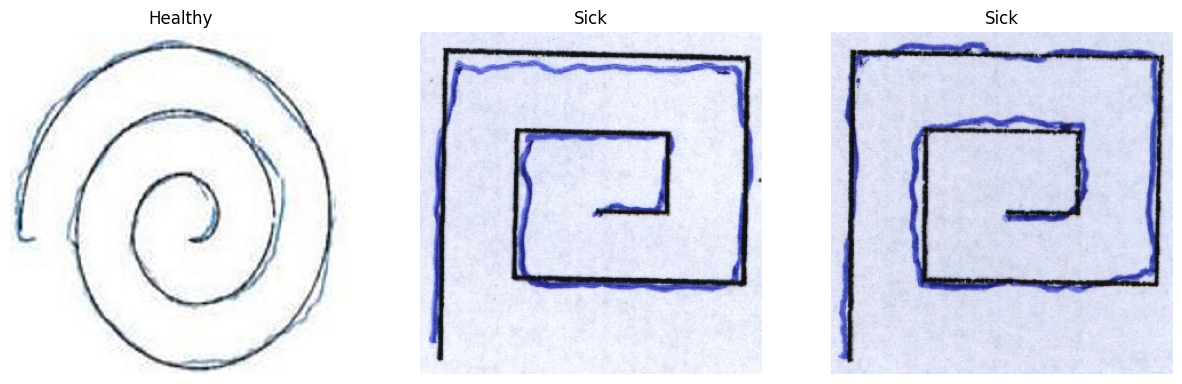

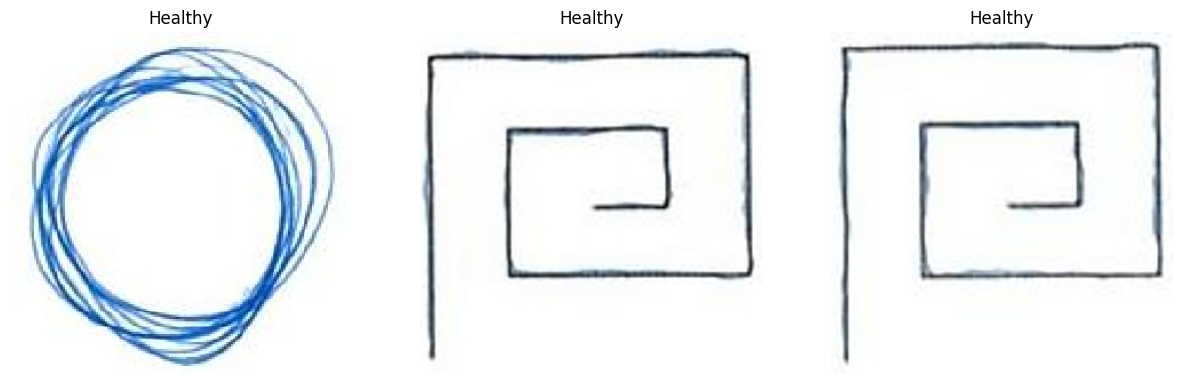

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample_images(generator, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, label = next(generator)  # Get a batch of images
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0])  # Show the first image of the batch
        plt.title(class_names[int(label[0])])  # Convert label to integer index
        plt.axis('off')
    plt.show()

# Visualize a sample of images from the train set
visualize_sample_images(train_generator, ['Healthy', 'Sick'], 3)
visualize_sample_images(val_generator, ['Healthy', 'Sick'], 3)
visualize_sample_images(test_generator, ['Healthy', 'Sick'], 3)

## Feature extraction

### InceptionV4 feature extraction 

In [130]:
import os
import joblib
from tqdm import tqdm
from PIL import Image
from PIL import Image
import torch
import timm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Iv4 = timm.create_model('inception_v4', pretrained=True)
model_Iv4.eval().to(device)
output_path = "C:\\Users\\sirin\\Desktop\\newhandpd\\data"
# Calculate steps for each generator
train_steps = len(train_generator)  # Number of batches = Total images / Batch size
val_steps = len(val_generator)
test_steps = len(test_generator)

In [131]:
# Define image preprocessing for InceptionV4
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    
])

# Extract features from an image
def extract_features(model, image):
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        features = model.forward_features(image_tensor)
        return features.squeeze().cpu().numpy()

# Convert numpy.ndarray to PIL.Image
def numpy_to_pil(image_np):
    return Image.fromarray(image_np.astype('uint8'), 'RGB')

In [132]:
def extract_features_and_save(generator, model, transform, output_path, total_steps):
    os.makedirs(output_path, exist_ok=True)

    for i in tqdm(range(total_steps), desc="Extracting features"):
        batch_images, batch_labels = next(generator)  # Get the next batch
        batch_features = []

        for image_np in batch_images:
            image = Image.fromarray((image_np * 255).astype('uint8'))
            feature = extract_features(model, image)  # Extract features
            batch_features.append(feature)

        batch_filename = os.path.join(output_path, f"batch_{i}.pkl")
        joblib.dump((np.array(batch_features), batch_labels), batch_filename)
        print(f"Saved batch {i} to {batch_filename}")

In [133]:
# Extract and save features for train, validation, and test sets
extract_features_and_save(train_generator, model_Iv4, transform, "train_features", total_steps=train_steps)
extract_features_and_save(val_generator, model_Iv4, transform, "val_features", total_steps=val_steps)
extract_features_and_save(test_generator, model_Iv4, transform, "test_features", total_steps=test_steps)

Extracting features:   4%|▍         | 1/23 [00:09<03:26,  9.40s/it]

Saved batch 0 to train_features\batch_0.pkl


Extracting features:   9%|▊         | 2/23 [00:26<04:46, 13.65s/it]

Saved batch 1 to train_features\batch_1.pkl


Extracting features:  13%|█▎        | 3/23 [00:45<05:23, 16.19s/it]

Saved batch 2 to train_features\batch_2.pkl


Extracting features:  17%|█▋        | 4/23 [01:04<05:29, 17.32s/it]

Saved batch 3 to train_features\batch_3.pkl


Extracting features:  22%|██▏       | 5/23 [01:20<05:02, 16.81s/it]

Saved batch 4 to train_features\batch_4.pkl


Extracting features:  26%|██▌       | 6/23 [01:31<04:11, 14.82s/it]

Saved batch 5 to train_features\batch_5.pkl


Extracting features:  30%|███       | 7/23 [01:39<03:22, 12.68s/it]

Saved batch 6 to train_features\batch_6.pkl


Extracting features:  35%|███▍      | 8/23 [01:47<02:48, 11.26s/it]

Saved batch 7 to train_features\batch_7.pkl


Extracting features:  39%|███▉      | 9/23 [01:55<02:24, 10.29s/it]

Saved batch 8 to train_features\batch_8.pkl


Extracting features:  43%|████▎     | 10/23 [02:03<02:05,  9.64s/it]

Saved batch 9 to train_features\batch_9.pkl


Extracting features:  48%|████▊     | 11/23 [02:12<01:49,  9.16s/it]

Saved batch 10 to train_features\batch_10.pkl


Extracting features:  52%|█████▏    | 12/23 [02:20<01:37,  8.86s/it]

Saved batch 11 to train_features\batch_11.pkl


Extracting features:  57%|█████▋    | 13/23 [02:28<01:26,  8.61s/it]

Saved batch 12 to train_features\batch_12.pkl


Extracting features:  61%|██████    | 14/23 [02:36<01:16,  8.47s/it]

Saved batch 13 to train_features\batch_13.pkl


Extracting features:  65%|██████▌   | 15/23 [02:44<01:06,  8.33s/it]

Saved batch 14 to train_features\batch_14.pkl


Extracting features:  70%|██████▉   | 16/23 [02:52<00:57,  8.29s/it]

Saved batch 15 to train_features\batch_15.pkl


Extracting features:  74%|███████▍  | 17/23 [03:01<00:50,  8.36s/it]

Saved batch 16 to train_features\batch_16.pkl


Extracting features:  78%|███████▊  | 18/23 [03:09<00:41,  8.33s/it]

Saved batch 17 to train_features\batch_17.pkl


Extracting features:  83%|████████▎ | 19/23 [03:17<00:32,  8.24s/it]

Saved batch 18 to train_features\batch_18.pkl


Extracting features:  87%|████████▋ | 20/23 [03:26<00:25,  8.36s/it]

Saved batch 19 to train_features\batch_19.pkl


Extracting features:  91%|█████████▏| 21/23 [03:34<00:16,  8.26s/it]

Saved batch 20 to train_features\batch_20.pkl


Extracting features:  96%|█████████▌| 22/23 [03:42<00:08,  8.23s/it]

Saved batch 21 to train_features\batch_21.pkl


Extracting features: 100%|██████████| 23/23 [03:44<00:00,  9.76s/it]


Saved batch 22 to train_features\batch_22.pkl


Extracting features:  12%|█▎        | 1/8 [00:07<00:54,  7.77s/it]

Saved batch 0 to val_features\batch_0.pkl


Extracting features:  25%|██▌       | 2/8 [00:15<00:45,  7.51s/it]

Saved batch 1 to val_features\batch_1.pkl


Extracting features:  38%|███▊      | 3/8 [00:22<00:37,  7.43s/it]

Saved batch 2 to val_features\batch_2.pkl


Extracting features:  50%|█████     | 4/8 [00:29<00:29,  7.39s/it]

Saved batch 3 to val_features\batch_3.pkl


Extracting features:  62%|██████▎   | 5/8 [00:37<00:22,  7.52s/it]

Saved batch 4 to val_features\batch_4.pkl


Extracting features:  75%|███████▌  | 6/8 [00:44<00:14,  7.49s/it]

Saved batch 5 to val_features\batch_5.pkl


Extracting features:  88%|████████▊ | 7/8 [00:52<00:07,  7.53s/it]

Saved batch 6 to val_features\batch_6.pkl


Extracting features: 100%|██████████| 8/8 [00:55<00:00,  7.00s/it]


Saved batch 7 to val_features\batch_7.pkl


Extracting features:  12%|█▎        | 1/8 [00:07<00:52,  7.51s/it]

Saved batch 0 to test_features\batch_0.pkl


Extracting features:  25%|██▌       | 2/8 [00:14<00:44,  7.49s/it]

Saved batch 1 to test_features\batch_1.pkl


Extracting features:  38%|███▊      | 3/8 [00:22<00:37,  7.59s/it]

Saved batch 2 to test_features\batch_2.pkl


Extracting features:  50%|█████     | 4/8 [00:29<00:29,  7.46s/it]

Saved batch 3 to test_features\batch_3.pkl


Extracting features:  62%|██████▎   | 5/8 [00:37<00:21,  7.33s/it]

Saved batch 4 to test_features\batch_4.pkl


Extracting features:  75%|███████▌  | 6/8 [00:44<00:14,  7.35s/it]

Saved batch 5 to test_features\batch_5.pkl


Extracting features:  88%|████████▊ | 7/8 [00:51<00:07,  7.27s/it]

Saved batch 6 to test_features\batch_6.pkl


Extracting features: 100%|██████████| 8/8 [00:54<00:00,  6.85s/it]

Saved batch 7 to test_features\batch_7.pkl


In [134]:
import joblib
import numpy as np
import os

def load_features_from_directory(directory):
    all_features = []
    all_labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            file_path = os.path.join(directory, filename)
            features, labels = joblib.load(file_path)
            all_features.append(features)
            all_labels.append(labels)

    return np.vstack(all_features), np.hstack(all_labels)

train_features_Iv4, train_labels = load_features_from_directory("train_features")
val_features_Iv4, val_labels = load_features_from_directory("val_features")
test_features_Iv4, test_labels = load_features_from_directory("test_features")

print("Train features shape:", train_features_Iv4.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", val_features_Iv4.shape)
print("Validation labels shape:", val_labels.shape)
print("Test features shape:", test_features_Iv4.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: (356, 1536, 8, 8)
Train labels shape: (356,)
Validation features shape: (119, 1536, 8, 8)
Validation labels shape: (119,)
Test features shape: (119, 1536, 8, 8)
Test labels shape: (119,)


In [135]:
# Apply Global Average Pooling (GAP)
train_features_Iv4 = np.mean(train_features_Iv4, axis=(2, 3))
val_features_Iv4 = np.mean(val_features_Iv4, axis=(2, 3))
test_features_Iv4 = np.mean(test_features_Iv4, axis=(2, 3))
print("After GAP, train_features_Iv4 shape:", train_features_Iv4.shape)
print("After GAP, val_features_Iv4 shape:", val_features_Iv4.shape)
print("After GAP, val_features_Iv4 shape:", test_features_Iv4.shape)


After GAP, train_features_Iv4 shape: (356, 1536)
After GAP, val_features_Iv4 shape: (119, 1536)
After GAP, val_features_Iv4 shape: (119, 1536)


### DeiT

In [139]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DeiT model
model_deit = timm.create_model('deit_base_patch16_224', pretrained=True)
model_deit.eval().to(device)

# Image preprocessing transformation for DeiT
transform_deit = transforms.Compose([
    
    transforms.Resize((224, 224)),  # DeiT requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [142]:
# Feature extraction function
# Feature extraction function
def extract_features_with_deit(model, image):
    """
    Extracts features from a single image using DeiT.
    Args:
        model: The DeiT model.
        image: A PIL image.
    Returns:
        Feature vector (numpy array).
    """
    with torch.no_grad():
        image_tensor = transform_deit(image).unsqueeze(0).to(device)  # Use transform_deit, not transform
        features = model.forward_features(image_tensor)  # Use forward_features for feature extraction
        return features.squeeze().cpu().numpy()


# Feature extraction and saving function
def extract_and_save_features(generator, model, transform_deit, output_path, total_steps):
    """
    Extracts features for a dataset and saves them to disk.
    """
    os.makedirs(output_path, exist_ok=True)
    for i in tqdm(range(total_steps), desc="Extracting features"):
        batch_images, batch_labels = next(generator)
        batch_features = []

        for image_np in batch_images:
            # Convert NumPy image array to PIL image and apply resizing
            image = Image.fromarray((image_np * 255).astype('uint8')).convert('RGB')
            feature = extract_features_with_deit(model, image)
            batch_features.append(feature)

        # Save features and labels for the batch
        batch_filename = os.path.join(output_path, f"batch_{i}.pkl")
        joblib.dump((np.array(batch_features), batch_labels), batch_filename)



In [143]:
# Extract and save features for train, validation, and test sets
extract_and_save_features(train_generator, model_deit, transform_deit, "train_features_deit", total_steps=train_steps)
extract_and_save_features(val_generator, model_deit, transform_deit, "val_features_deit", total_steps=val_steps)
extract_and_save_features(test_generator, model_deit, transform_deit, "test_features_deit", total_steps=test_steps)

Extracting features: 100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


In [144]:
train_features_deit, train_labels_deit = load_features_from_directory("train_features_deit")
val_features_deit, val_labels_deit = load_features_from_directory("val_features_deit")
test_features_deit, test_labels_deit = load_features_from_directory("test_features_deit")

print("Train features shape:", train_features_deit.shape)
print("Train labels shape:", train_labels_deit.shape)
print("Validation features shape:", val_features_deit.shape)
print("Validation labels shape:", val_labels_deit.shape)
print("Test features shape:", test_features_deit.shape)
print("Test labels shape:", test_labels_deit.shape)

# Apply Global Average Pooling (GAP)
train_features_deit = np.mean(train_features_deit, axis=1)
val_features_deit = np.mean(val_features_deit, axis=1)
test_features_deit = np.mean(test_features_deit, axis=1)

print("After GAP, train_features shape:", train_features_deit.shape)
print("After GAP, val_features shape:", val_features_deit.shape)
print("After GAP, test_features shape:", test_features_deit.shape)

Train features shape: (356, 197, 768)
Train labels shape: (356,)
Validation features shape: (119, 197, 768)
Validation labels shape: (119,)
Test features shape: (119, 197, 768)
Test labels shape: (119,)
After GAP, train_features shape: (356, 768)
After GAP, val_features shape: (119, 768)
After GAP, test_features shape: (119, 768)


### Edge and Contours Features

In [145]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler

# Function to extract edge and contour features from an image
def extract_edge_contour_features(image, max_contours=10):
    """
    Extract edge and contour features from the given image and ensure that all feature vectors
    have a fixed size (padding or truncating as necessary).
    """
    # Convert image to grayscale (ensure it's uint8 format)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Ensure image is in 8-bit format
    img = np.uint8(img)

    # Edge detection using Canny
    edges = cv2.Canny(img, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract features from contours
    contour_features = []
    for contour in contours[:max_contours]:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        fourier_desc = np.fft.fft(contour[:, 0, :])  # Apply FFT to extract frequency domain features
        fourier_desc = np.abs(fourier_desc).mean()  # Average magnitude of Fourier descriptors

        contour_features.extend([area, perimeter, fourier_desc])

    # Pad or truncate to ensure fixed length
    if len(contour_features) < max_contours * 3:
        contour_features.extend([0] * (max_contours * 3 - len(contour_features)))
    elif len(contour_features) > max_contours * 3:
        contour_features = contour_features[:max_contours * 3]

    return np.array(contour_features)

# Function to process a batch of images and extract features
def extract_batch_features(generator, max_contours=10, total_images=512):
    features = []
    labels = []
    img_count = 0  # Track the number of images processed

    for images, batch_labels in generator:
        for img, label in zip(images, batch_labels):
            img_count += 1
            print(f"Processing image {img_count}")
            
            # Break the loop when total_images are processed
            if img_count > total_images:
                print("Stopping: All images processed.")
                return np.array(features), np.array(labels)
            
            contour_features = extract_edge_contour_features(img, max_contours)
            if contour_features is not None:
                features.append(contour_features)
                labels.append(label)

    return np.array(features), np.array(labels)



# Extract features for train, validation, and test data
train_features_edge, train_labels_edge = extract_batch_features(train_generator, max_contours=10, total_images=356)
val_features_edge, val_labels_edge = extract_batch_features(val_generator, max_contours=10, total_images=119)
test_features_edge, test_labels_edge = extract_batch_features(test_generator, max_contours=10, total_images=119)


Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing image 50
Processin

In [146]:
train_features_edge.shape

(356, 30)

In [147]:
print("Feature dimensions before concatenation:")
print("InceptionV4:", train_features_Iv4.shape)
print("DeiT:", train_features_deit.shape)
print("Edge features:", train_features_edge.shape)


Feature dimensions before concatenation:
InceptionV4: (356, 1536)
DeiT: (356, 768)
Edge features: (356, 30)


In [148]:
# Combine Features
train_combined_features = np.concatenate((train_features_Iv4, train_features_deit, train_features_edge), axis=1)
val_combined_features = np.concatenate((val_features_Iv4, val_features_deit, val_features_edge), axis=1)
test_combined_features = np.concatenate((test_features_Iv4, test_features_deit, test_features_edge), axis=1)

In [149]:
# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_combined_features)
X_val_scaled = scaler.transform(val_combined_features)
X_test_scaled = scaler.transform(test_combined_features)

### RFECV

In [155]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
# Define the classifier to use for RFE
clf = SVC(kernel="linear")

# Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define RFECV
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=cv,  # Cross-validation strategy
    scoring='accuracy',  # Scoring metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# Fit RFECV on the training data
rfecv.fit(X_train_scaled, train_labels)

# Select Important Features
# Mask of selected features
selected_features_mask = rfecv.support_

# Apply mask to training, validation, and test sets
X_train_selected = X_train_scaled[:, selected_features_mask]
X_val_selected = X_val_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# 4. Print Results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features (indices): {np.where(selected_features_mask)[0]}")

Fitting estimator with 2334 features.
Fitting estimator with 2333 features.
Fitting estimator with 2332 features.
Fitting estimator with 2331 features.
Fitting estimator with 2330 features.
Fitting estimator with 2329 features.
Fitting estimator with 2328 features.
Fitting estimator with 2327 features.
Fitting estimator with 2326 features.
Fitting estimator with 2325 features.
Fitting estimator with 2324 features.
Fitting estimator with 2323 features.
Fitting estimator with 2322 features.
Fitting estimator with 2321 features.
Fitting estimator with 2320 features.
Fitting estimator with 2319 features.
Fitting estimator with 2318 features.
Fitting estimator with 2317 features.
Fitting estimator with 2316 features.
Fitting estimator with 2315 features.
Fitting estimator with 2314 features.
Fitting estimator with 2313 features.
Fitting estimator with 2312 features.
Fitting estimator with 2311 features.
Fitting estimator with 2310 features.
Fitting estimator with 2309 features.
Fitting esti

In [156]:
# 5. Train the Classifier with Selected Features
clf.fit(X_train_selected, train_labels)
val_score = clf.score(X_val_selected, val_labels)
test_score = clf.score(X_test_selected, test_labels)

print(f"Validation Accuracy: {val_score}")
print(f"Test Accuracy: {test_score}") #527 svc 

Validation Accuracy: 0.7478991596638656
Test Accuracy: 0.7983193277310925


In [157]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier  # Import Gradient Boosting

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
# Define the Gradient Boosting classifier to use for RFE
clf = GradientBoostingClassifier(random_state=42)

# Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define RFECV
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=cv,  # Cross-validation strategy
    scoring='accuracy',  # Scoring metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# Fit RFECV on the training data
rfecv.fit(X_train_scaled, train_labels)

# Select Important Features
# Mask of selected features
selected_features_mask = rfecv.support_

# Apply mask to training, validation, and test sets
X_train_selected = X_train_scaled[:, selected_features_mask]
X_val_selected = X_val_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Print Results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features (indices): {np.where(selected_features_mask)[0]}")

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
# Define the Random Forest classifier to use for RFE
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define RFECV
rfecv = RFECV(
    estimator=clf,
    step=1,  # Number of features to remove at each iteration
    cv=cv,  # Cross-validation strategy
    scoring='accuracy',  # Scoring metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

# Fit RFECV on the training data
rfecv.fit(X_train_scaled, train_labels)

# Select Important Features
# Mask of selected features
selected_features_mask = rfecv.support_

# Apply mask to training, validation, and test sets
X_train_selected = X_train_scaled[:, selected_features_mask]
X_val_selected = X_val_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Print Results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features (indices): {np.where(selected_features_mask)[0]}")


## Classification

### KNN with combined Features + feature selection

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_selected, train_labels)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(X_train_selected, train_labels)
val_accuracy = best_knn.score(X_val_selected, val_labels)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(X_test_selected, test_labels)
print("Test set accuracy:", test_accuracy)

# Get predictions for further analysis
test_predictions = best_knn.predict(X_test_selected)

# Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Best parameters: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}
Best score: 0.8118544600938966
Validation accuracy: 0.7058823529411765
Test set accuracy: 0.7478991596638656
Confusion Matrix:
[[39 24]
 [ 6 50]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.62      0.72        63
         1.0       0.68      0.89      0.77        56

    accuracy                           0.75       119
   macro avg       0.77      0.76      0.75       119
weighted avg       0.78      0.75      0.74       119



### KNN with inceptionv4 features

In [152]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(train_features_Iv4, train_labels)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(train_features_Iv4, train_labels)
val_accuracy = best_knn.score(val_features_Iv4, val_labels)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(test_features_Iv4, test_labels)
print("Test set accuracy:", test_accuracy)

# Get predictions for further analysis
test_predictions = best_knn.predict(test_features_Iv4)

# Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Best score: 0.7640453834115805
Validation accuracy: 0.6974789915966386
Test set accuracy: 0.680672268907563
Confusion Matrix:
[[54  9]
 [29 27]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.86      0.74        63
         1.0       0.75      0.48      0.59        56

    accuracy                           0.68       119
   macro avg       0.70      0.67      0.66       119
weighted avg       0.70      0.68      0.67       119



### KNN with Deit

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(train_features_deit, train_labels)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(train_features_deit, train_labels)
val_accuracy = best_knn.score(val_features_deit, val_labels)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(test_features_deit, test_labels)
print("Test set accuracy:", test_accuracy)

# Get predictions for further analysis
test_predictions = best_knn.predict(test_features_deit)

# Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'chebyshev'}
Best score: 0.5139280125195619
Validation accuracy: 0.4789915966386555
Test set accuracy: 0.453781512605042
Confusion Matrix:
[[32 31]
 [34 22]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.51      0.50        63
         1.0       0.42      0.39      0.40        56

    accuracy                           0.45       119
   macro avg       0.45      0.45      0.45       119
weighted avg       0.45      0.45      0.45       119



### KNN with Edge features

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(train_features_edge, train_labels_edge)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(train_features_edge, train_labels_edge)
val_accuracy = best_knn.score(val_features_edge, val_labels_edge)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(test_features_edge, test_labels_edge)
print("Test set accuracy:", test_accuracy)

# Get predictions for further analysis
test_predictions = best_knn.predict(test_features_edge)

# Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Best parameters: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'chebyshev'}
Best score: 0.5311032863849766
Validation accuracy: 0.5294117647058824
Test set accuracy: 0.5294117647058824
Confusion Matrix:
[[63  0]
 [56  0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69        63
         1.0       0.00      0.00      0.00        56

    accuracy                           0.53       119
   macro avg       0.26      0.50      0.35       119
weighted avg       0.28      0.53      0.37       119



C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

### KNN with combined features (no selection)

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid and RandomizedSearchCV
param_grid = {
    'n_neighbors': [3, 5],  # A broader range of neighbors
    'weights': ['uniform', 'distance'],      # Test both uniform and distance weighting
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Common distance metrics
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_grid, n_iter=20, cv=10, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, train_labels)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Train and evaluate the best KNN model
best_knn = KNeighborsClassifier(**random_search.best_params_)
best_knn.fit(X_train_scaled, train_labels)
val_accuracy = best_knn.score(X_val_scaled, val_labels)
print("Validation accuracy:", val_accuracy)


# Evaluate the best KNN model on the test set
test_accuracy = best_knn.score(X_test_scaled, test_labels)
print("Test set accuracy:", test_accuracy)

# Get predictions for further analysis
test_predictions = best_knn.predict(X_test_scaled)

# Print confusion matrix and classification report for detailed evaluation
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_predictions))

print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))

C:\Users\sirin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}
Best score: 0.75
Validation accuracy: 0.6722689075630253
Test set accuracy: 0.6302521008403361
Confusion Matrix:
[[52 11]
 [33 23]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.83      0.70        63
         1.0       0.68      0.41      0.51        56

    accuracy                           0.63       119
   macro avg       0.64      0.62      0.61       119
weighted avg       0.64      0.63      0.61       119



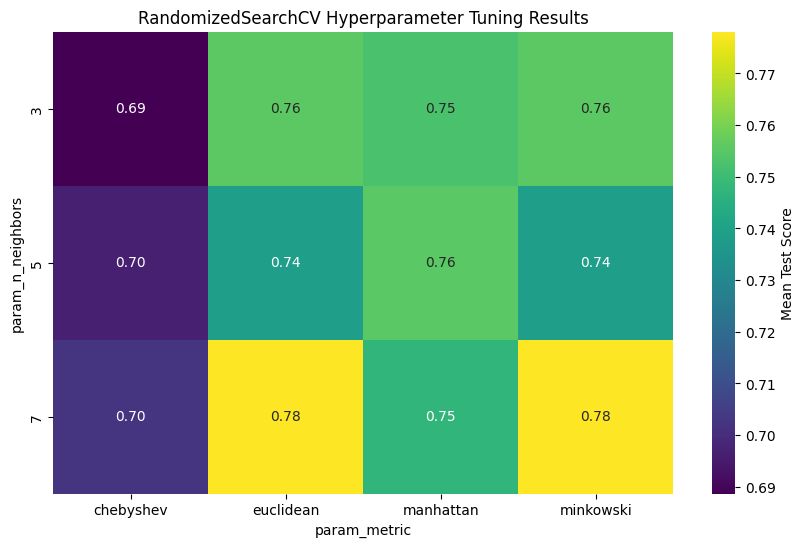

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize hyperparameter tuning results
results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.heatmap(results.pivot_table(index='param_n_neighbors', columns='param_metric', values='mean_test_score'),
            annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Mean Test Score'})
plt.title('RandomizedSearchCV Hyperparameter Tuning Results')
plt.show()


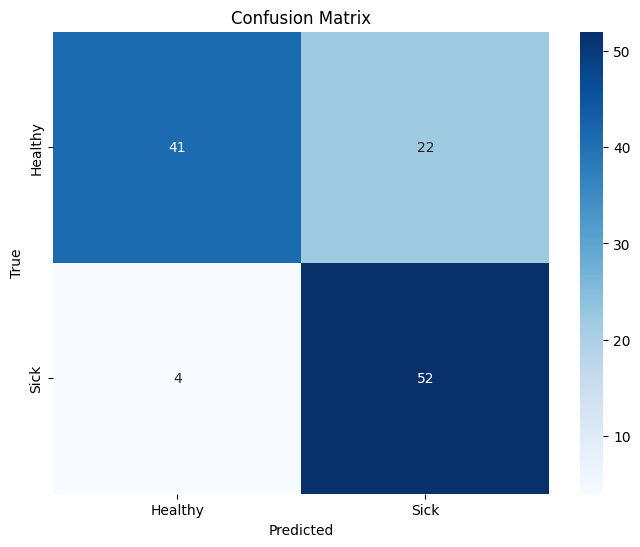

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76        63
         1.0       0.70      0.93      0.80        56

    accuracy                           0.78       119
   macro avg       0.81      0.79      0.78       119
weighted avg       0.81      0.78      0.78       119



In [127]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrix for test set predictions
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, ['Healthy', 'Sick'])

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions))
